In [1]:
import os
import cftime
import dask
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from create_ocean_mask import levitus98

from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=16, processes=False)

from mem_track import used_memory
used_memory()

used 136.695312 MB


/storage1/home1/chiaweih/anaconda2/envs/python3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


# ssl 5000

In [2]:
##############################################################################
#### possible input info from external text file
# constant setting
syear = 1993
fyear = 2017
tp_lat_region = [-30,30]     # extract model till latitude
depthint = 5000
# depthint = 400

# regional mean range
lon_range_list = [[120,180],[180,-60],[120,-60]]    # Lon: -180-180
lat_range_list = [[-20,20],[-20,20],[-20,20]]

# inputs
datadir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/EN4/'
datafile = 'EN.4.2.1.f.analysis.g10.ssl'
varname = 'ssl'


# output dir
dir_out = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/EN4/regional_avg/'

In [3]:
################################################################
# # Read dataset
#
# read in as dask array to avoid memory overload

import warnings
warnings.simplefilter("ignore")

#### data
import sys

ds_data_list = {}
mean_list = {}
season_list = {}

# concat data into one dataset
for yy in range(syear,fyear+1):
    for mm in range(1,13): 
        ds0=xr.open_dataset(datadir+'%s%i.%0.4i%0.2i.nc'%(datafile,depthint,yy,mm))
        ds0=ds0.rename(name_dict={'__xarray_dataarray_variable__':varname})
        da0=ds0[varname]
        if yy == syear and mm == 1 :
            da=da0.copy()
        else:
            da=xr.concat([da,da0],dim='time')

# mask land area
da = da.where(da>1E-13,other=np.nan)

# crop data (lat)
da = da.where((da.lat >= np.min(np.array(tp_lat_region)))&
              (da.lat <= np.max(np.array(tp_lat_region)))
              ,drop=True)

# store all model data
ds_data_list['dep%i'%(depthint)] = da

# # calculate mean
# mean_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].mean(dim='time').compute()
# ds_data_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)]-mean_list['dep%i'%(depthint)]

# # calculate seasonality
# season_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].groupby('time.month').mean(dim='time').compute()
# ds_data_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].groupby('time.month')-season_list['dep%i'%(depthint)]


used_memory()

used 219.437500 MB


In [4]:
# read mask dataset
ds_pac = levitus98(ds_data_list['dep%i'%(depthint)],
                    basin=['pac'],reuse_weights=True, newvar=True,
                    lon_name='lon',lat_name='lat', new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [5]:
from spherical_area import cal_area
def area(da_lon,da_lat):
    da_area=xr.apply_ufunc(cal_area,
                           da_lon,da_lat,1.0,1.0,
                           input_core_dims=[[],[],[],[]],
                           vectorize=True,
                           output_dtypes=[np.dtype(np.float64)],
                           dask='parallelized')
    return da_area

In [6]:
# initialize dictionary  (exec this cell will remove all previous calculated values for all variables)
regional_var_list = {}

for nn in range(len(lon_range_list)):
    print('process',lon_range_list[nn],lat_range_list[nn])

    #### setting individual event year range
    lon_range  = lon_range_list[nn]
    lat_range  = lat_range_list[nn]
    
    # correct the lon range
    lon_range_mod = np.array(lon_range)
    ind1 = np.where(lon_range_mod<np.float(0.))[0]
    lon_range_mod[ind1] = lon_range_mod[ind1]+360. # change Lon range to 0-360 

    # crop region
    ds_mask = ds_pac.where(\
                          (ds_pac.lon>=np.min(lon_range_mod))&\
                          (ds_pac.lon<=np.max(lon_range_mod))&\
                          (ds_pac.lat>=np.min(lat_range))&\
                          (ds_pac.lat<=np.max(lat_range))\
                           ).compute()

    # calculate area
    da_area=area(da.lon,da.lat)*ds_mask        # m^2


    # calculate regional mean
    regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
    = ((ds_data_list['dep%i'%(depthint)]*ds_mask*da_area).sum(dim=['lon','lat'])/(ds_mask*da_area).sum(dim=['lon','lat'])).compute()

#     fileout = '%s_%s_regional_avg_ts_scpt.nc'%(varname,depthint)

#     if not os.path.exists(dir_out):
#         os.makedirs(dir_out)
#     try:
#         regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
#         .to_netcdf(dir_out+fileout,mode='a')
#     except FileNotFoundError:
#         regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
#         .to_netcdf(dir_out+fileout,mode='w')

process [120, 180] [-20, 20]
process [180, -60] [-20, 20]
process [120, -60] [-20, 20]


# ssl 400

In [7]:
##############################################################################
#### possible input info from external text file
# constant setting
syear = 1993
fyear = 2017
tp_lat_region = [-30,30]     # extract model till latitude
depthint = 400

# regional mean range
lon_range_list = [[120,180],[180,-60],[120,-60]]    # Lon: -180-180
lat_range_list = [[-20,20],[-20,20],[-20,20]]

# inputs
datadir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/EN4/'
datafile = 'EN.4.2.1.f.analysis.g10.ssl'
varname = 'ssl'


# output dir
dir_out = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/EN4/regional_avg/'

In [8]:
################################################################
# # Read dataset
#
# read in as dask array to avoid memory overload

import warnings
warnings.simplefilter("ignore")

#### data
import sys

ds_data_list = {}
mean_list = {}
season_list = {}

# concat data into one dataset
for yy in range(syear,fyear+1):
    for mm in range(1,13): 
        ds0=xr.open_dataset(datadir+'%s%i.%0.4i%0.2i.nc'%(datafile,depthint,yy,mm))
        ds0=ds0.rename(name_dict={'__xarray_dataarray_variable__':varname})
        da0=ds0[varname]
        if yy == syear and mm == 1 :
            da=da0.copy()
        else:
            da=xr.concat([da,da0],dim='time')

# mask land area
da = da.where(da>1E-13,other=np.nan)

# crop data (lat)
da = da.where((da.lat >= np.min(np.array(tp_lat_region)))&
              (da.lat <= np.max(np.array(tp_lat_region)))
              ,drop=True)

# store all model data
ds_data_list['dep%i'%(depthint)] = da

# # calculate mean
# mean_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].mean(dim='time').compute()
# ds_data_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)]-mean_list['dep%i'%(depthint)]

# # calculate seasonality
# season_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].groupby('time.month').mean(dim='time').compute()
# ds_data_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].groupby('time.month')-season_list['dep%i'%(depthint)]


used_memory()

used 257.128906 MB


In [9]:
# read mask dataset
ds_pac = levitus98(ds_data_list['dep%i'%(depthint)],
                    basin=['pac'],reuse_weights=True, newvar=True,
                    lon_name='lon',lat_name='lat', new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [10]:
for nn in range(len(lon_range_list)):
    print('process',lon_range_list[nn],lat_range_list[nn])

    #### setting individual event year range
    lon_range  = lon_range_list[nn]
    lat_range  = lat_range_list[nn]
    
    # correct the lon range
    lon_range_mod = np.array(lon_range)
    ind1 = np.where(lon_range_mod<np.float(0.))[0]
    lon_range_mod[ind1] = lon_range_mod[ind1]+360. # change Lon range to 0-360 

    # crop region
    ds_mask = ds_pac.where(\
                          (ds_pac.lon>=np.min(lon_range_mod))&\
                          (ds_pac.lon<=np.max(lon_range_mod))&\
                          (ds_pac.lat>=np.min(lat_range))&\
                          (ds_pac.lat<=np.max(lat_range))\
                           ).compute()

    # calculate area
    da_area=area(da.lon,da.lat)*ds_mask        # m^2


    # calculate regional mean
    regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
    = ((ds_data_list['dep%i'%(depthint)]*ds_mask*da_area).sum(dim=['lon','lat'])/(ds_mask*da_area).sum(dim=['lon','lat'])).compute()

#     fileout = '%s_%s_regional_avg_ts_scpt.nc'%(varname,depthint)

#     if not os.path.exists(dir_out):
#         os.makedirs(dir_out)
#     try:
#         regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
#         .to_netcdf(dir_out+fileout,mode='a')
#     except FileNotFoundError:
#         regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
#         .to_netcdf(dir_out+fileout,mode='w')

process [120, 180] [-20, 20]
process [180, -60] [-20, 20]
process [120, -60] [-20, 20]


# tssl 400

In [11]:
##############################################################################
#### possible input info from external text file
# constant setting
syear = 1993
fyear = 2017
tp_lat_region = [-30,30]     # extract model till latitude
depthint = 400

# regional mean range
lon_range_list = [[120,180],[180,-60],[120,-60]]    # Lon: -180-180
lat_range_list = [[-20,20],[-20,20],[-20,20]]

# inputs
datadir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/EN4/'
datafile = 'EN.4.2.1.f.analysis.g10.dtssl'
varname = 'tssl'


# output dir
dir_out = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/EN4/regional_avg/'

In [12]:
da

<xarray.DataArray 'ssl' (time: 300, lat: 61, lon: 360)>
array([[[407.735122, 407.742371, ..., 407.745438, 407.740468],
        [407.709947, 407.714516, ..., 407.722356, 407.716407],
        ...,
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       [[407.7296  , 407.736267, ..., 407.74292 , 407.735072],
        [407.699955, 407.704345, ..., 407.71498 , 407.706335],
        ...,
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       ...,

       [[407.681601, 407.690232, ..., 407.682057, 407.680172],
        [407.646684, 407.650955, ..., 407.648951, 407.646227],
        ...,
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       [[407.706319, 407.712487, ..., 407.708951, 407.7074  ],
        [407.668085, 407.669299, ..., 407.673842, 407.670884],
    

In [13]:
################################################################
# # Read dataset
#
# read in as dask array to avoid memory overload

import warnings
warnings.simplefilter("ignore")

#### data
import sys

ds_data_list = {}
mean_list = {}
season_list = {}

# concat data into one dataset
for yy in range(syear,fyear+1):
    for mm in range(1,13): 
        if yy == syear and mm == 1:
            print("no tssl first month")
        else:
            ds0=xr.open_dataset(datadir+'%s%i_test.%0.4i%0.2i.nc'%(datafile,depthint,yy,mm))
            ds0=ds0.rename(name_dict={'__xarray_dataarray_variable__':varname})
            da0=ds0[varname]
            if yy == syear and mm == 2 :
                da=da0.copy()
            else:
                da=xr.concat([da,da0],dim='time')

# mask land area
# da = da.where(da>1E-13,other=np.nan)

# crop data (lat)
da = da.where((da.lat >= np.min(np.array(tp_lat_region)))&
              (da.lat <= np.max(np.array(tp_lat_region)))
              ,drop=True)

# store all model data
ds_data_list['dep%i'%(depthint)] = da

# # calculate mean
# mean_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].mean(dim='time').compute()
# ds_data_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)]-mean_list['dep%i'%(depthint)]

# # calculate seasonality
# season_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].groupby('time.month').mean(dim='time').compute()
# ds_data_list['dep%i'%(depthint)] = ds_data_list['dep%i'%(depthint)].groupby('time.month')-season_list['dep%i'%(depthint)]


used_memory()

no tssl first month
used 309.273438 MB


In [14]:
# read mask dataset
ds_pac = levitus98(ds_data_list['dep%i'%(depthint)],
                    basin=['pac'],reuse_weights=True, newvar=True,
                    lon_name='lon',lat_name='lat', new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [15]:
for nn in range(len(lon_range_list)):
    print('process',lon_range_list[nn],lat_range_list[nn])

    #### setting individual event year range
    lon_range  = lon_range_list[nn]
    lat_range  = lat_range_list[nn]
    
    # correct the lon range
    lon_range_mod = np.array(lon_range)
    ind1 = np.where(lon_range_mod<np.float(0.))[0]
    lon_range_mod[ind1] = lon_range_mod[ind1]+360. # change Lon range to 0-360 

    # crop region
    ds_mask = ds_pac.where(\
                          (ds_pac.lon>=np.min(lon_range_mod))&\
                          (ds_pac.lon<=np.max(lon_range_mod))&\
                          (ds_pac.lat>=np.min(lat_range))&\
                          (ds_pac.lat<=np.max(lat_range))\
                           ).compute()

    # calculate area
    da_area=area(da.lon,da.lat)*ds_mask        # m^2


    # calculate regional mean
    regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
    = ((ds_data_list['dep%i'%(depthint)]*ds_mask*da_area).sum(dim=['lon','lat'])/(ds_mask*da_area).sum(dim=['lon','lat'])).compute()

#     fileout = '%s_%s_regional_avg_ts_scpt.nc'%(varname,depthint)

#     if not os.path.exists(dir_out):
#         os.makedirs(dir_out)
#     try:
#         regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
#         .to_netcdf(dir_out+fileout,mode='a')
#     except FileNotFoundError:
#         regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
#         .to_netcdf(dir_out+fileout,mode='w')

process [120, 180] [-20, 20]
process [180, -60] [-20, 20]
process [120, -60] [-20, 20]


# CMEMS sl

In [16]:
#### possible input info from external text file
# constant setting
obs_year_range = [[1993,2018,9]]

tp_lat_region = [-30,30]     # extract model till latitude

Obs_varname = [['adt']]

Obs_name = ['CMEMS']

# inputs
obsin = {}
obspath = {}

obs = Obs_name[0]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/CMEMS/'
obsfile = [['dt_global_allsat_phy_l4_monthly_adt.nc']]
obspath[obs]=[obsdir,obsfile]


for nobs,obs in enumerate(Obs_name):
    obsdir = obspath[obs][0]
    obsfile = obspath[obs][1]
    multivar = []
    for file in obsfile :
        if len(file) == 1 :
            multivar.append([os.path.join(obsdir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(obsdir,ff))
            multivar.append(multifile)
    obsin[obs] = multivar

In [17]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_obs_mlist = {}
obs_mean_mlist = {}
obs_season_mlist = {}
obs_linear_mlist = {}

In [18]:
import spherical_area as sa

#### obs
for nobs,obs in enumerate(Obs_name):
    ds_obs_list = {}
    obs_mean_list = {}
    obs_season_list = {}
    obs_linear_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        print('read %s %s'%(obs,var))
        
        # read input data
        #-- single file
        if len(obsin[obs][nvar]) == 1 :  
            
            # find out dimension name 
            da = xr.open_dataset(obsin[obs][nvar][0],chunks={})
            obsdims = list(da[var].dims)
        
            ds_obs = xr.open_dataset(obsin[obs][nvar][0],chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
         
        #-- multi-file merge (same variable)
        elif len(obsin[obs][nvar]) > 1 :
            for nf,file in enumerate(obsin[obs][nvar]):
                # find out dimension name 
                da = xr.open_dataset(file,chunks={})
                obsdims = list(da[var].dims)
            
                ds_obs_sub = xr.open_dataset(file,chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
                if nf == 0 :
                    ds_obs = ds_obs_sub
                else:
                    ds_obs = xr.concat([ds_obs,ds_obs_sub],dim='time',data_vars='minimal')
                    
        ############## CMEMS ##############       
        if obs in ['CMEMS']:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            fmon_obs = obs_year_range[nobs][2]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,fmon_obs,1),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax                   
                 
            # calculate global mean sea level 
            da_area = sa.da_area(ds_obs, lonname='longitude', latname='latitude', 
                                 xname='longitude', yname='latitude', model=None)
            da_glo_mean = (ds_obs*da_area).sum(dim=['longitude','latitude'])/da_area.sum(dim=['longitude','latitude'])
#             ds_obs = ds_obs-da_glo_mean

            # rename 
            ds_obs = ds_obs.rename({'longitude':'lon','latitude':'lat'})
        else:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,12,31),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax
            
     
        # crop data (time)
        ds_obs = ds_obs[var]\
                          .where((ds_obs['time.year'] >= syear)&\
                                 (ds_obs['time.year'] <= fyear)\
                                 ,drop=True)
        ds_obs = ds_obs\
                          .where((ds_obs.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_obs.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_obs_list[var] = ds_obs
        
#         # calculate mean 
#         obs_mean_list[var] = ds_obs_list[var].mean(dim='time').compute()
#         ds_obs_list[var] = ds_obs_list[var]-obs_mean_list[var]
        
#         # calculate seasonality
#         obs_season_list[var] = ds_obs_list[var].groupby('time.month').mean(dim='time').compute()
#         ds_obs_list[var] = ds_obs_list[var].groupby('time.month')-obs_season_list[var]
        
#         # remove linear trend 
#         obs_linear_list[var] = da_linregress(ds_obs_list[var].load(),xname='lon',yname='lat',stTconfint=0.99,skipna=True) 

#     obs_linear_mlist[obs] = obs_linear_list
#     obs_mean_mlist[obs] = obs_mean_list
#     obs_season_mlist[obs] = obs_season_list
    ds_obs_mlist[obs] = ds_obs_list

read CMEMS adt


In [19]:
# read mask dataset
ds_pac = levitus98(ds_obs_list[Obs_varname[0][0]],
                    basin=['pac'],reuse_weights=True, newvar=True,
                    lon_name='lon',lat_name='lat', new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [20]:
for nn in range(len(lon_range_list)):
    print('process',lon_range_list[nn],lat_range_list[nn])

    #### setting individual event year range
    lon_range  = lon_range_list[nn]
    lat_range  = lat_range_list[nn]
    
    # correct the lon range
    lon_range_mod = np.array(lon_range)
    ind1 = np.where(lon_range_mod<np.float(0.))[0]
    lon_range_mod[ind1] = lon_range_mod[ind1]+360. # change Lon range to 0-360 

    # crop region
    ds_mask = ds_pac.where(\
                          (ds_pac.lon>=np.min(lon_range_mod))&\
                          (ds_pac.lon<=np.max(lon_range_mod))&\
                          (ds_pac.lat>=np.min(lat_range))&\
                          (ds_pac.lat<=np.max(lat_range))\
                           ).compute()

    # calculate area
    da_area=area(ds_obs_list[Obs_varname[0][0]].lon,ds_obs_list[Obs_varname[0][0]].lat)*ds_mask        # m^2


    # calculate regional mean
    regional_var_list['%s_%i_%i_%i_%i'%(Obs_varname[0][0],lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
    = ((ds_obs_list[Obs_varname[0][0]]*ds_mask*da_area).sum(dim=['lon','lat'])/(ds_mask*da_area).sum(dim=['lon','lat'])).compute()
    
    regional_var_list['%s_%i_%i_%i_%i'%(Obs_varname[0][0],lon_range[0],lon_range[1],lat_range[0],lat_range[1])] \
     = regional_var_list['%s_%i_%i_%i_%i'%(Obs_varname[0][0],lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
    .where(regional_var_list['%s_%i_%i_%i_%i'%(Obs_varname[0][0],lon_range[0],lon_range[1],lat_range[0],lat_range[1])] != 0. 
           ,drop=True)

#     fileout = '%s_%s_regional_avg_ts_scpt.nc'%(varname,depthint)

#     if not os.path.exists(dir_out):
#         os.makedirs(dir_out)
#     try:
#         regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
#         .to_netcdf(dir_out+fileout,mode='a')
#     except FileNotFoundError:
#         regional_var_list['%s_dep%i_%i_%i_%i_%i'%(varname,depthint,lon_range[0],lon_range[1],lat_range[0],lat_range[1])]\
#         .to_netcdf(dir_out+fileout,mode='w')

process [120, 180] [-20, 20]
process [180, -60] [-20, 20]
process [120, -60] [-20, 20]


In [21]:
def var_exp(ts1,ts2):
    
    sumts = ts1+ts2
    ts1 = ts1*sumts/sumts
    ts2 = ts2*sumts/sumts
    slope, intercept, r_value, pval, std_err = stats.linregress(ts1.values,ts2.values)
    return r_value**2

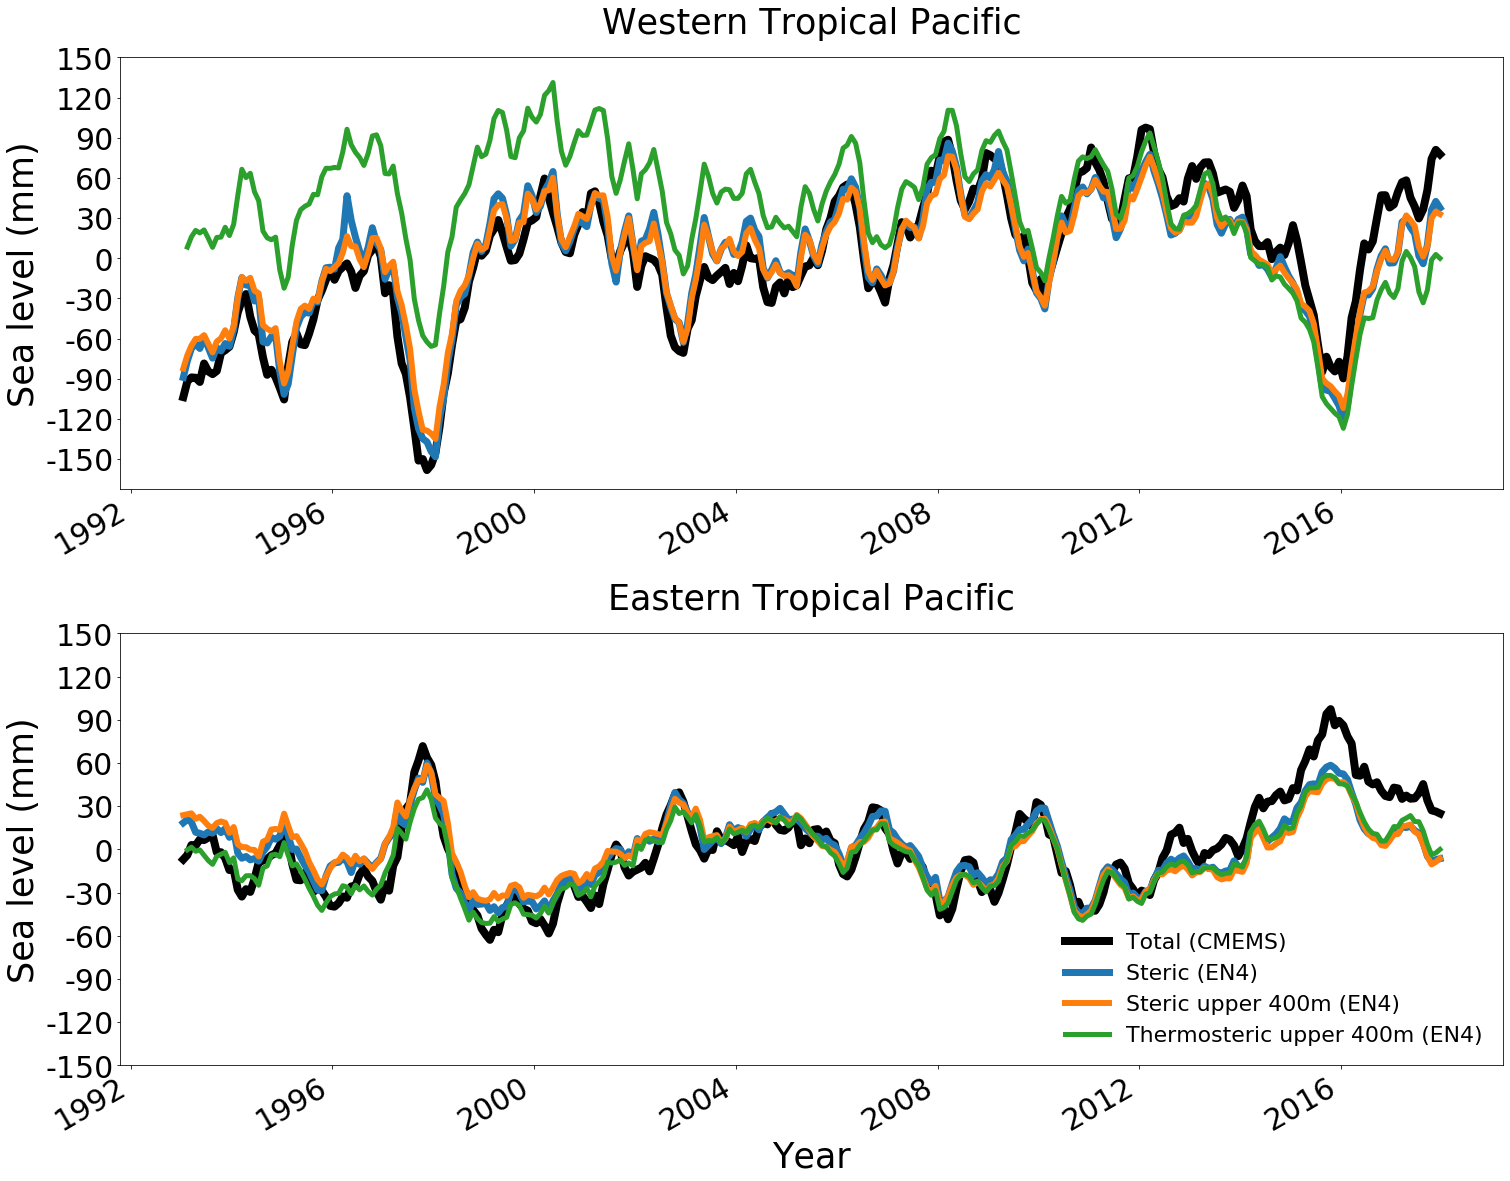

In [30]:
import matplotlib.pyplot as plt
import datetime
from scipy import stats

fig=plt.figure(figsize=(24,10))
ax1=fig.add_axes([0,0,0.8,0.6])

region = '120_180_-20_20'
ssl = regional_var_list['ssl_dep5000_%s'%region]-regional_var_list['ssl_dep5000_%s'%region].mean()
ssl400 = regional_var_list['ssl_dep400_%s'%region]-regional_var_list['ssl_dep400_%s'%region].mean()
tssl400 = (regional_var_list['tssl_dep400_%s'%region]-regional_var_list['tssl_dep400_%s'%region].mean()).cumsum()
sl = regional_var_list['adt_%s'%region]-regional_var_list['adt_%s'%region].mean()
sl['time'] = ssl.time

sl.plot(ax=ax1,label='Total (CMEMS)',linewidth=8.0,color='k',linestyle='solid')

varexp = var_exp(ssl,sl)
ssl.plot(ax=ax1,label='Steric (EN4)',linewidth=7.0)

varexp = var_exp(ssl400,ssl)
ssl400.plot(ax=ax1,label='Steric upper 400m (EN4)',linewidth=6.0)

varexp = var_exp(tssl400,ssl400)
tssl400.plot(ax=ax1,label='Thermosteric (EN4)',linewidth=5.0)





sllevel=np.linspace(-0.15,0.15,11)

#### setting the plotting format
ax1.set_ylabel('Sea level (mm)',{'size':'35'})
ax1.tick_params(axis='y',labelsize=30) 
# ax1.grid(linestyle='dashed',axis='both')
ax1.set_xlabel('',{'size':'20'})
ax1.set_title("Western Tropical Pacific",{'size':'35'},pad=24)     
ax1.tick_params(axis='x',labelsize=30) 
ax1.set_yticks(sllevel)
ax1.set_yticklabels(['%2.0f'%tick for tick in sllevel*1000.])
# ax1.legend(loc='lower right',fontsize=15,frameon=False)


ax2=fig.add_axes([0,-0.8,0.8,0.6])

region = '180_-60_-20_20'

ssl = regional_var_list['ssl_dep5000_%s'%region]-regional_var_list['ssl_dep5000_%s'%region].mean()
ssl400 = regional_var_list['ssl_dep400_%s'%region]-regional_var_list['ssl_dep400_%s'%region].mean()
tssl400 = (regional_var_list['tssl_dep400_%s'%region]-regional_var_list['tssl_dep400_%s'%region].mean()).cumsum()
sl = regional_var_list['adt_%s'%region]-regional_var_list['adt_%s'%region].mean()

sl['time'] = ssl.time

sl.plot(ax=ax2,label='Total (CMEMS)',linewidth=8.0,color='k',linestyle='solid')

varexp = var_exp(ssl,sl)
ssl.plot(ax=ax2,label='Steric (EN4)',linewidth=7.0)

varexp = var_exp(ssl400,ssl)
ssl400.plot(ax=ax2,label='Steric upper 400m (EN4)',linewidth=6.0)

varexp = var_exp(tssl400,ssl400)
tssl400.plot(ax=ax2,label='Thermosteric upper 400m (EN4)',linewidth=5.0)






sllevel=np.linspace(-0.15,0.15,11)

#### setting the plotting format
ax2.set_ylabel('Sea level (mm)',{'size':'35'})
ax2.tick_params(axis='y',labelsize=30) 
# ax2.grid(linestyle='dashed',axis='both')
ax2.set_xlabel('Year',{'size':'35'})
ax2.set_title("Eastern Tropical Pacific",{'size':'35'},pad=24)     
ax2.tick_params(axis='x',labelsize=30) 
ax2.set_yticks(sllevel)
ax2.set_yticklabels(['%2.0f'%tick for tick in sllevel*1000.])
ax2.legend(loc='lower right',fontsize=22,frameon=False)


fig.savefig('../figure/figure1_ext.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

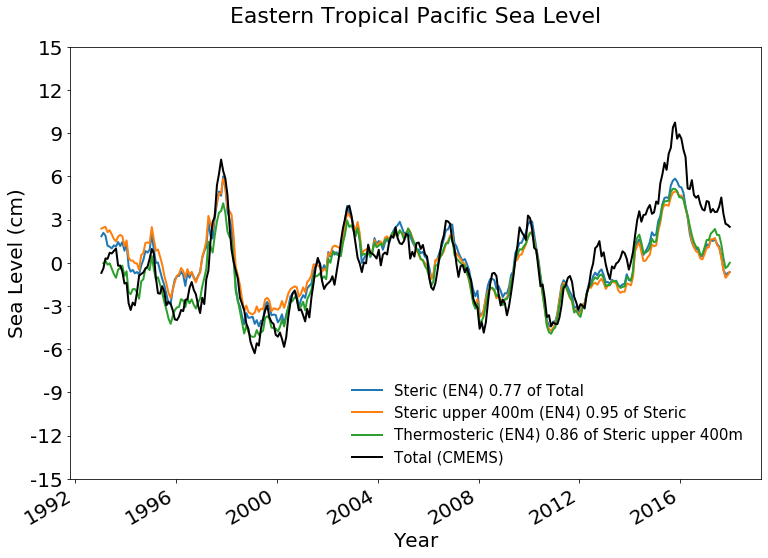

In [23]:
import matplotlib.pyplot as plt
import datetime
from scipy import stats


fig=plt.figure(figsize=(12,10))
ax1=fig.add_axes([0,0,0.8,0.6])

region = '180_-60_-20_20'

ssl = regional_var_list['ssl_dep5000_%s'%region]-regional_var_list['ssl_dep5000_%s'%region].mean()
ssl400 = regional_var_list['ssl_dep400_%s'%region]-regional_var_list['ssl_dep400_%s'%region].mean()
tssl400 = (regional_var_list['tssl_dep400_%s'%region]-regional_var_list['tssl_dep400_%s'%region].mean()).cumsum()
sl = regional_var_list['adt_%s'%region]-regional_var_list['adt_%s'%region].mean()

sl['time'] = ssl.time

varexp = var_exp(ssl,sl)
ssl.plot(ax=ax1,label='Steric (EN4) %0.2f of Total'%varexp,linewidth=2.0)

varexp = var_exp(ssl400,ssl)
ssl400.plot(ax=ax1,label='Steric upper 400m (EN4) %0.2f of Steric'%varexp,linewidth=2.0)

varexp = var_exp(tssl400,ssl400)
tssl400.plot(ax=ax1,label='Thermosteric (EN4) %0.2f of Steric upper 400m '%varexp,linewidth=2.0)

sl.plot(ax=ax1,label='Total (CMEMS)',linewidth=2.0,color='k')




sllevel=np.linspace(-0.15,0.15,11)

#### setting the plotting format
ax1.set_ylabel('Sea Level (cm)',{'size':'20'})
ax1.tick_params(axis='y',labelsize=20) 
# ax1.grid(linestyle='dashed',axis='both')
ax1.set_xlabel('Year',{'size':'20'})
ax1.set_title("Eastern Tropical Pacific Sea Level",{'size':'22'},pad=24)     
ax1.tick_params(axis='x',labelsize=20) 
ax1.set_yticks(sllevel)
ax1.set_yticklabels(['%2.0f'%tick for tick in sllevel*100.])
ax1.legend(loc='lower right',fontsize=15,frameon=False)



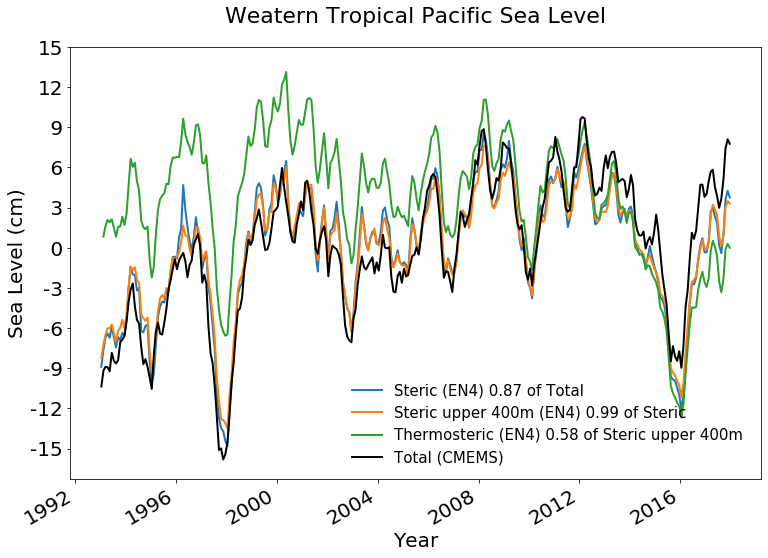

In [24]:
import matplotlib.pyplot as plt
import datetime

fig=plt.figure(figsize=(12,10))
ax1=fig.add_axes([0,0,0.8,0.6])

region = '120_180_-20_20'
ssl = regional_var_list['ssl_dep5000_%s'%region]-regional_var_list['ssl_dep5000_%s'%region].mean()
ssl400 = regional_var_list['ssl_dep400_%s'%region]-regional_var_list['ssl_dep400_%s'%region].mean()
tssl400 = (regional_var_list['tssl_dep400_%s'%region]-regional_var_list['tssl_dep400_%s'%region].mean()).cumsum()
sl = regional_var_list['adt_%s'%region]-regional_var_list['adt_%s'%region].mean()
sl['time'] = ssl.time

varexp = var_exp(ssl,sl)
ssl.plot(ax=ax1,label='Steric (EN4) %0.2f of Total'%varexp,linewidth=2.0)

varexp = var_exp(ssl400,ssl)
ssl400.plot(ax=ax1,label='Steric upper 400m (EN4) %0.2f of Steric'%varexp,linewidth=2.0)

varexp = var_exp(tssl400,ssl400)
tssl400.plot(ax=ax1,label='Thermosteric (EN4) %0.2f of Steric upper 400m '%varexp,linewidth=2.0)

sl.plot(ax=ax1,label='Total (CMEMS)',linewidth=2.0,color='k')



sllevel=np.linspace(-0.15,0.15,11)

#### setting the plotting format
ax1.set_ylabel('Sea Level (cm)',{'size':'20'})
ax1.tick_params(axis='y',labelsize=20) 
# ax1.grid(linestyle='dashed',axis='both')
ax1.set_xlabel('Year',{'size':'20'})
ax1.set_title("Weatern Tropical Pacific Sea Level",{'size':'22'},pad=24)     
ax1.tick_params(axis='x',labelsize=20) 
ax1.set_yticks(sllevel)
ax1.set_yticklabels(['%2.0f'%tick for tick in sllevel*100.])
ax1.legend(loc='lower right',fontsize=15,frameon=False)



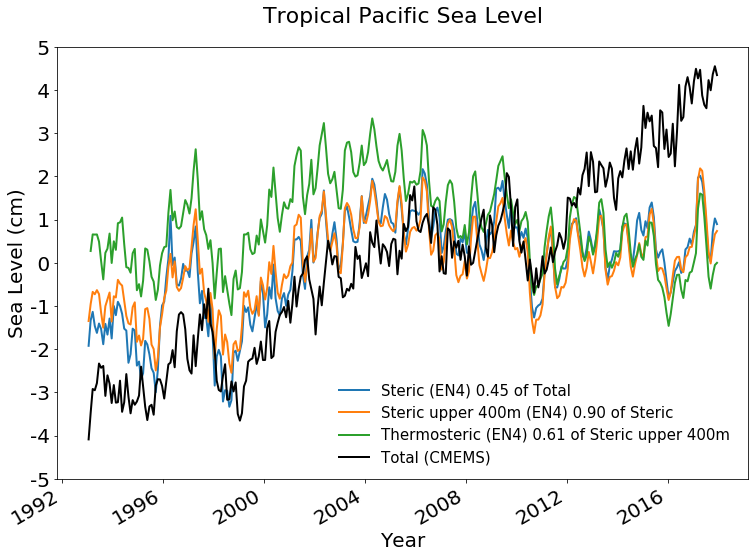

In [25]:
import matplotlib.pyplot as plt
import datetime

fig=plt.figure(figsize=(12,10))
ax1=fig.add_axes([0,0,0.8,0.6])

region = '120_-60_-20_20'
ssl = regional_var_list['ssl_dep5000_%s'%region]-regional_var_list['ssl_dep5000_%s'%region].mean()
ssl400 = regional_var_list['ssl_dep400_%s'%region]-regional_var_list['ssl_dep400_%s'%region].mean()
tssl400 = (regional_var_list['tssl_dep400_%s'%region]-regional_var_list['tssl_dep400_%s'%region].mean()).cumsum()
sl = regional_var_list['adt_%s'%region]-regional_var_list['adt_%s'%region].mean()
sl['time'] = ssl.time

varexp = var_exp(ssl,sl)
ssl.plot(ax=ax1,label='Steric (EN4) %0.2f of Total'%varexp,linewidth=2.0)

varexp = var_exp(ssl400,ssl)
ssl400.plot(ax=ax1,label='Steric upper 400m (EN4) %0.2f of Steric'%varexp,linewidth=2.0)

varexp = var_exp(tssl400,ssl400)
tssl400.plot(ax=ax1,label='Thermosteric (EN4) %0.2f of Steric upper 400m '%varexp,linewidth=2.0)

sl.plot(ax=ax1,label='Total (CMEMS)',linewidth=2.0,color='k')

sllevel=np.linspace(-0.05,0.05,11)

#### setting the plotting format
ax1.set_ylabel('Sea Level (cm)',{'size':'20'})
ax1.tick_params(axis='y',labelsize=20) 
# ax1.grid(linestyle='dashed',axis='both')
ax1.set_xlabel('Year',{'size':'20'})
ax1.set_title("Tropical Pacific Sea Level",{'size':'22'},pad=24)     
ax1.tick_params(axis='x',labelsize=20) 
ax1.set_yticks(sllevel)
ax1.set_yticklabels(['%2.0f'%tick for tick in sllevel*100.])
ax1.legend(loc='lower right',fontsize=15,frameon=False)

